In [15]:
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from utils import calculate_dissim, laplacian_dissim, calculate_dissim_unmatched
import pandas as pd
import random
from myst_nb import glue

# Comparing Discriminability - MaMI

We will run the same kernels on the [MaMI dataset](https://www.biorxiv.org/content/10.1101/2022.03.11.483995v1) (unmatched).

## Load Data

In [16]:
from pathlib import Path

graphs_all = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs_all[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

print(len(species_list))
    

225


In [17]:
random.seed(3)

# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders_all = info_df.pop("Order").to_list()

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders_all[i] == 'Artiodactyla':
        orders_all[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders_all[i]

labels_all = list(map(order_mapper.get, species_list))

# get subset of labels, graphs
orders = ['Chiroptera', 'Primates']
#orders = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']
ind_ch = []
ind_pr = []
labels = []

for i, label in enumerate(labels_all):
    if label == 'Chiroptera':
        #labels.append(label)
        ind_ch.append(i)
    elif label == 'Primates':
        #labels.append(label)
        ind_pr.append(i)

ind_ch_samp = random.sample(ind_ch, len(ind_ch)//2)
ind_pr_samp = random.sample(ind_pr, len(ind_pr)//2)

ind = ind_ch_samp + ind_pr_samp
ind.sort()
graphs = graphs_all[ind]
labels = list(np.array(labels_all)[ind])

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))


38
38


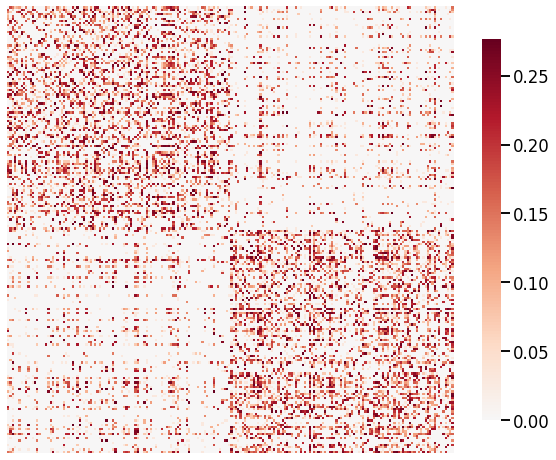

In [4]:
# Visualize one of the graphs
ax = heatmap(graphs[0], context='talk', transform='simple-all')
ax.figure.set_facecolor('w')

## Kernels

The following is a list of kernels that were implemented. We divided them into three major groups based on the metrics used.

- Global: Density, Average Edge Weight, Average of Adjacency Matrix
- Node-wise: Node Degree, Node Strength
- Edge-wise: Edge Weights

## Global Kernels

The following kernels are constructed using characteristics of the entire graph. For each metric, the absolute differences between every pair of graphs were calculated and visualized using a heatmap.

### Density
The density of each graph was calculated by dividing the number of edges by the number of possible nodes.

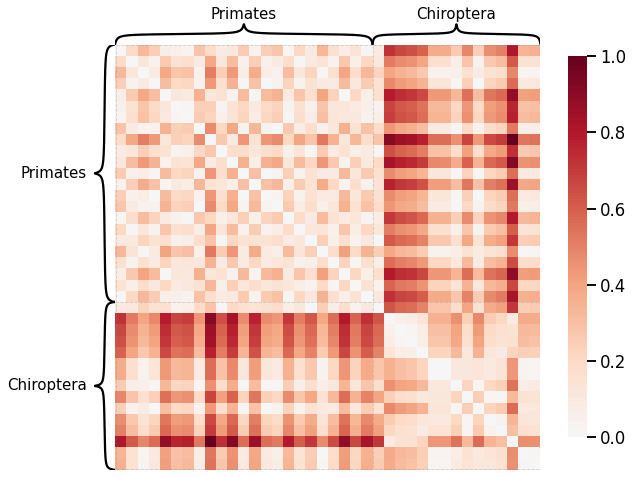

In [18]:
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

ax = heatmap(scaled_density_dissim, inner_hier_labels=labels, hier_label_fontsize=15, context="talk")
ax.figure.set_facecolor('w')

### Average Edge Weight

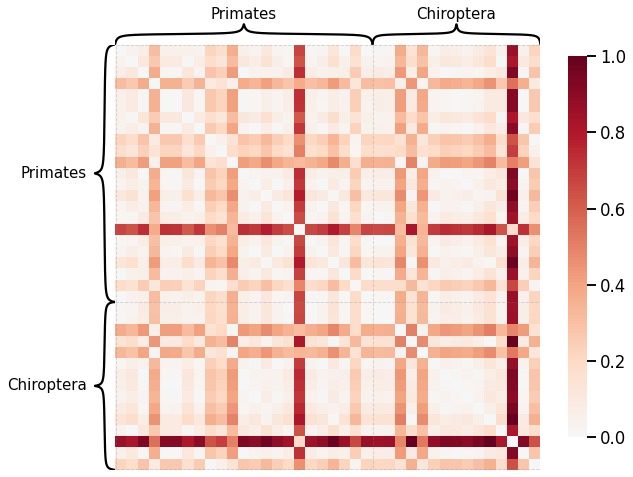

In [19]:
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix
Note that when we calculate the average of each adjacency matrix, we include edges that do not exist, whereas we only consider those with nonzero values when we calculate the average edge weight of each graph.

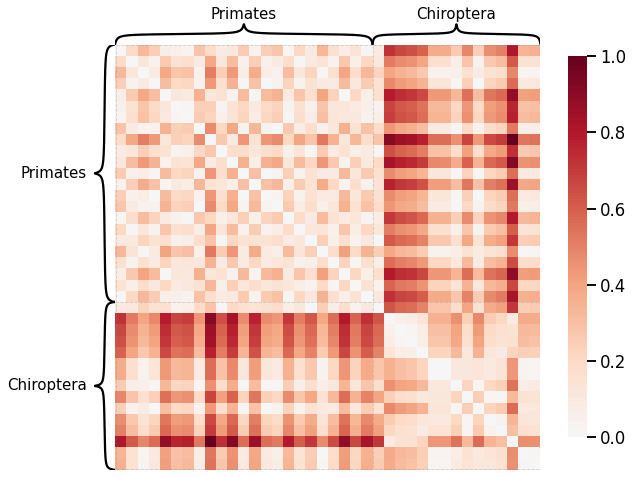

In [20]:
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Spectral Distance (Laplacian)

The spectral distance between networks was estimated by computing the difference between the Laplacian eigenspectrums. Each network was transformed using pass-to-ranks, and the L2 norm of the difference between the sorted eigenspectrums was calculated.

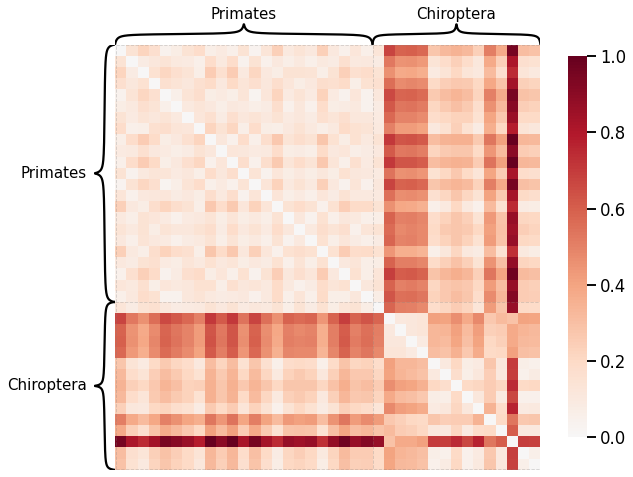

In [21]:
scaled_lap_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', normalize=True)

ax = heatmap(scaled_lap_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

For the kernels that follow, they assume that the nodes are matched. However, we are working with an umatched datset. Thus, we used the [two-sample Kolmogorov-Smirnov test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) to compare two distributions. 

## Node-wise Kernels
The following kernels use characteristics related to the nodes of each graph. For each metric, we calculate the two-sample Kolmogorov-Smirnov statistic between each graph.

### Node Degrees
The degree of a node in a graph is the number of nodes each node is adjacent to, aka the number of edges each node has.

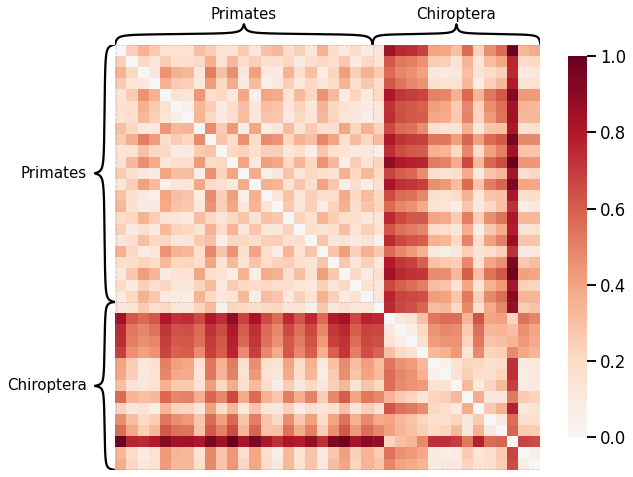

In [22]:
scaled_nodedeg_dissim = calculate_dissim_unmatched(graphs, method="degree", normalize=True)

ax = heatmap(scaled_nodedeg_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Node Strength
Node strength, unlike node degree, takes into account the weight of the edges each node has. We calculate node strength by finding the sum of the edge weights for each node.

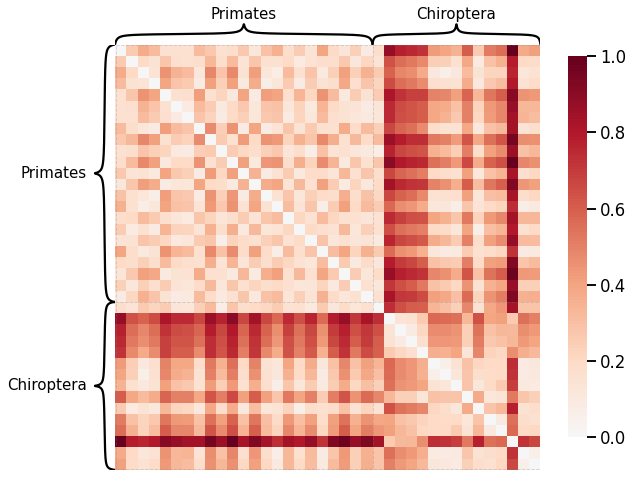

In [23]:
scaled_nodestr_dissim = calculate_dissim_unmatched(graphs, method="strength", normalize=True)

ax = heatmap(scaled_nodestr_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

## Edge-wise Kernels
The following kernels use characteristics related to the edges of each graph. For each metric, we calculated the two-sample Kolmogrov-Smirnov statistic between each graph.

### Edge weights
Here we compare the weights of each edge between graphs by simply subtracting one adjacency matrix from another.

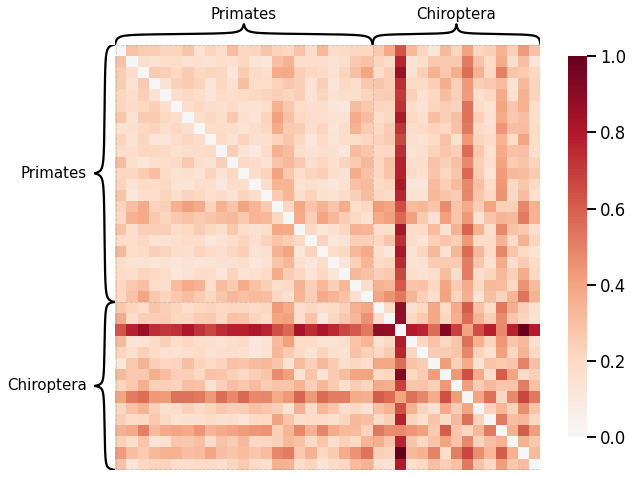

In [24]:
scaled_edgeweight_dissim = calculate_dissim_unmatched(graphs, method="edgeweight", normalize=True)

ax = heatmap(scaled_edgeweight_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15)
ax.figure.set_facecolor('w')

### Latent Distribution Test

Instead of using omnibus embedding that assumes the nodes are matched, we will use the [latent distribution test](https://microsoft.github.io/graspologic/latest/reference/reference/inference.html#graspologic.inference.latent_distribution_test) from Graspologic that determines whether two random dot product graphs with no known matching between the vertices have the same distributions of latent positions.

100%|██████████| 37/37 [1:00:54<00:00, 98.78s/it] 


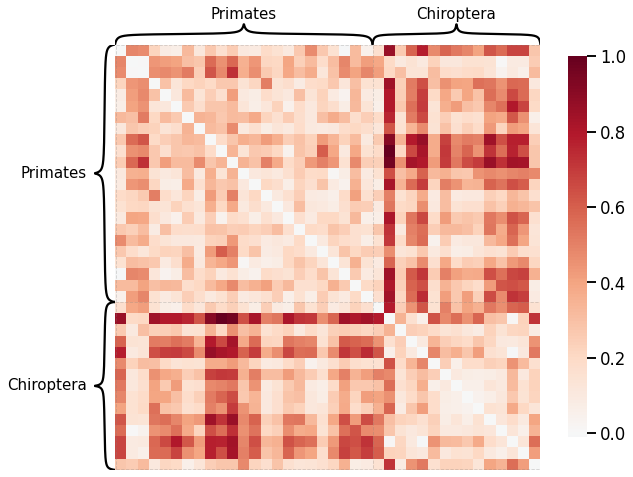

In [6]:
from graspologic.inference import latent_distribution_test
from graspologic.align import SeedlessProcrustes
from graspologic.plot import heatmap
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.utils import largest_connected_component
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

ase_graphs = []
for i, graph in enumerate(graphs):
    lcc_graph = largest_connected_component(graph)
    ase_graph = AdjacencySpectralEmbed(n_components=4).fit_transform(lcc_graph)
    ase_graphs.append(ase_graph)

# calculate alignments
latent_dissim = np.zeros((len(ase_graphs), len(ase_graphs)))
Qs = []
for j in tqdm(range(0, len(ase_graphs) - 1)):
    for i in range(j+1, len(ase_graphs)):
        #aligner = SeedlessProcrustes()
        #graph1 = aligner.fit_transform(ase_graphs[i], ase_graphs[j])
        #aligned_graphs.append(graph1)
        statistic, _, misc_dict = latent_distribution_test(ase_graphs[i], ase_graphs[j], test='mgc', metric='euclidean', \
            n_bootstraps=0, align_type='seedless_procrustes', input_graph=False)
        latent_dissim[i, j] = statistic
        Qs.append(misc_dict['Q'])

#aligned_graphs = np.array(aligned_graphs)

# plot heatmap
scaled_latent_dissim = latent_dissim / np.max(latent_dissim)
scaled_latent_dissim = scaled_latent_dissim + scaled_latent_dissim.T

mami_latent_dissim_fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(10, 10))
heatmap(scaled_latent_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=15, ax=ax)

glue("mami_latent_dissim", mami_latent_dissim_fig, display=False)

In [9]:
%store scaled_latent_dissim
%store Qs

Stored 'scaled_latent_dissim' (ndarray)
Stored 'Qs' (list)


#### Pairplots After Alignments

In [17]:
print(labels)

['Primates', 'Chiroptera', 'Primates', 'Primates', 'Chiroptera', 'Primates', 'Primates', 'Primates', 'Primates', 'Chiroptera', 'Primates', 'Primates', 'Primates', 'Chiroptera', 'Chiroptera', 'Primates', 'Primates', 'Chiroptera', 'Primates', 'Primates', 'Chiroptera', 'Primates', 'Chiroptera', 'Chiroptera', 'Primates', 'Primates', 'Primates', 'Chiroptera', 'Chiroptera', 'Primates', 'Chiroptera', 'Chiroptera', 'Primates', 'Primates', 'Primates', 'Chiroptera', 'Primates', 'Chiroptera']


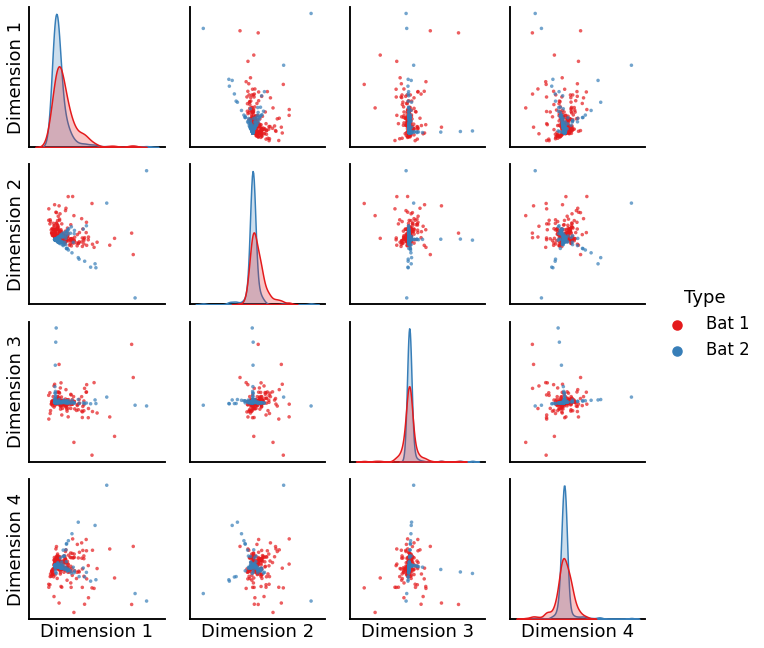

In [13]:
### Chiroptera (Bats)
from graspologic.plot import pairplot

aligner=SeedlessProcrustes()
graph_bat = aligner.fit_transform(ase_graphs[1], ase_graphs[4])

labels_bat = ['Bat 1'] * 200 + ['Bat 2'] * 200
X_bat = np.concatenate((graph_bat, ase_graphs[4]), axis=0)
plot_bat = pairplot(X_bat, labels_bat)

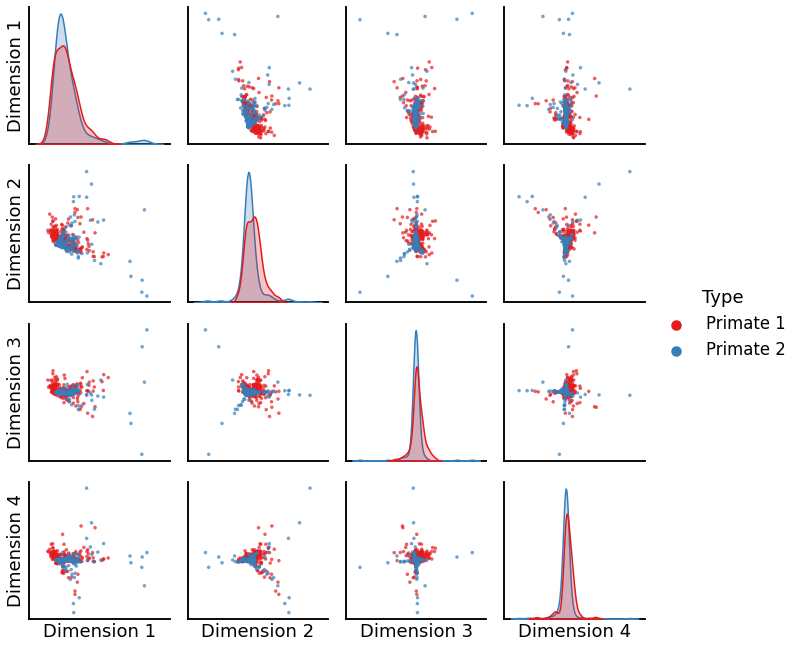

In [14]:
### Primates
aligner=SeedlessProcrustes()
graph_primate = aligner.fit_transform(ase_graphs[0], ase_graphs[2])

labels_primate = ['Primate 1'] * 200 + ['Primate 2'] * 200
X_primate = np.concatenate((graph_primate, ase_graphs[2]), axis=0)
plot_primate = pairplot(X_primate, labels_primate)

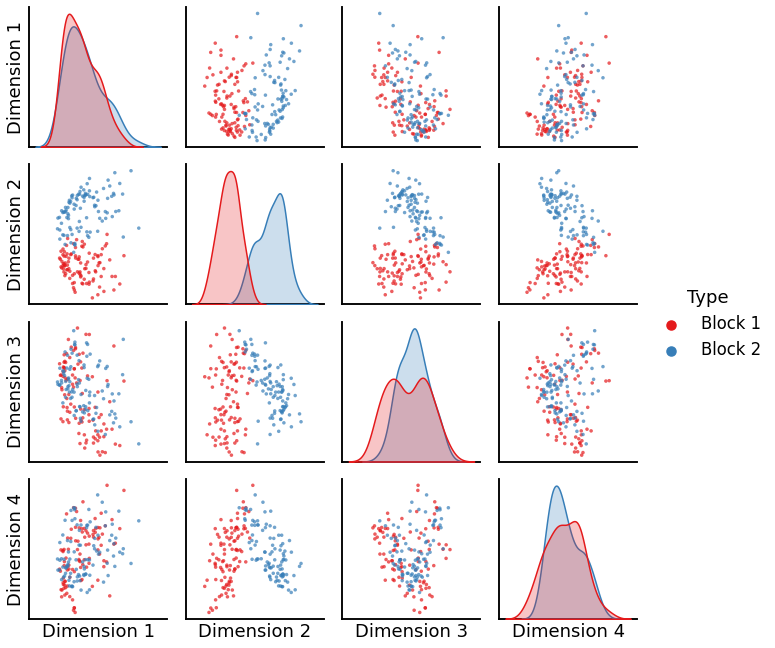

In [21]:
from graspologic.plot import pairplot

pairplot_labels = ['Block 1'] * 100 + ['Block 2'] * 100
primate1 = ase_graphs[0]

plot_primate1 = pairplot(primate1, pairplot_labels)
#plt.figure(facecolor='w')
plt.savefig('pairplot_primate1.jpg', bbox_inches='tight')

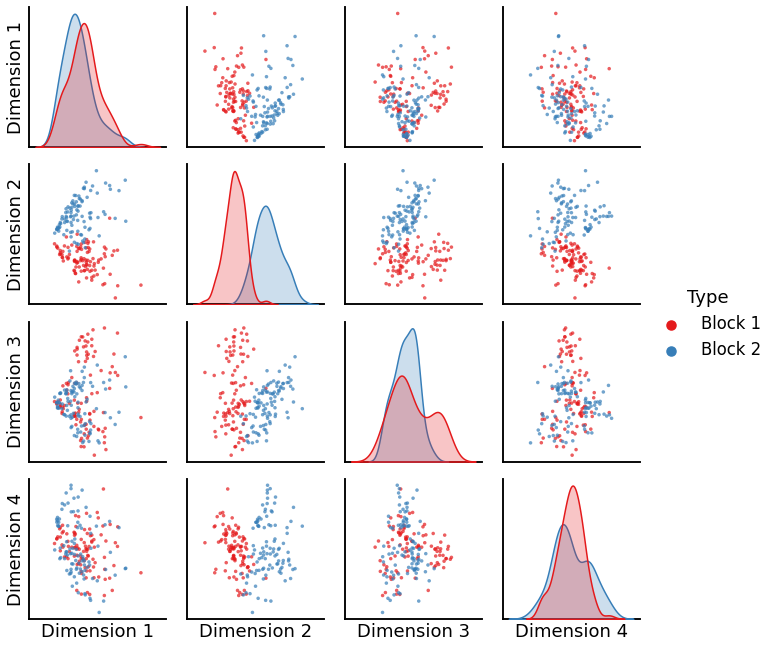

In [22]:
bat1 = ase_graphs[1]

plot_bat1 = pairplot(bat1, pairplot_labels)
#plt.figure(facecolor='w')
plt.savefig('pairplot_bat1.jpg', bbox_inches='tight')

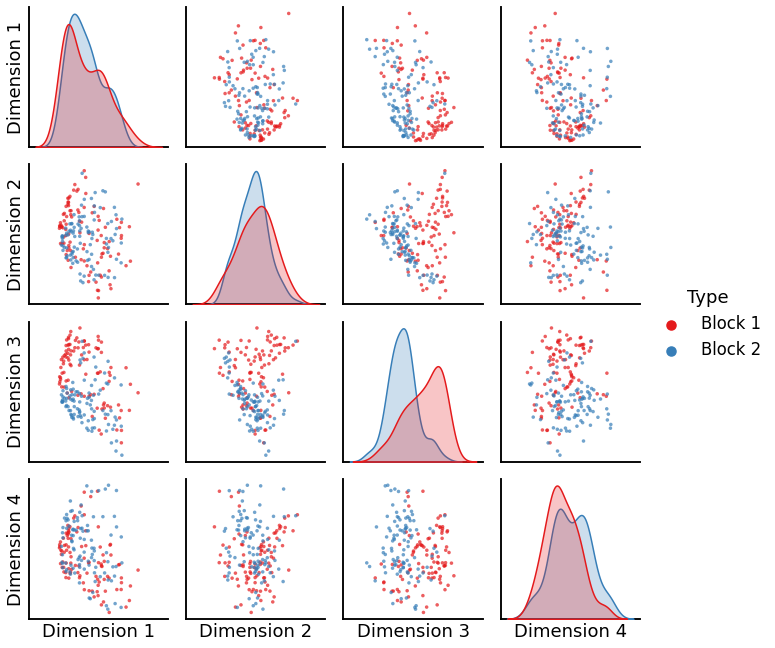

In [23]:
primate2 = ase_graphs[2]

plot_primate2 = pairplot(primate2, pairplot_labels)
#plt.figure(facecolor='w')
plt.savefig('pairplot_primate2.jpg', bbox_inches='tight')

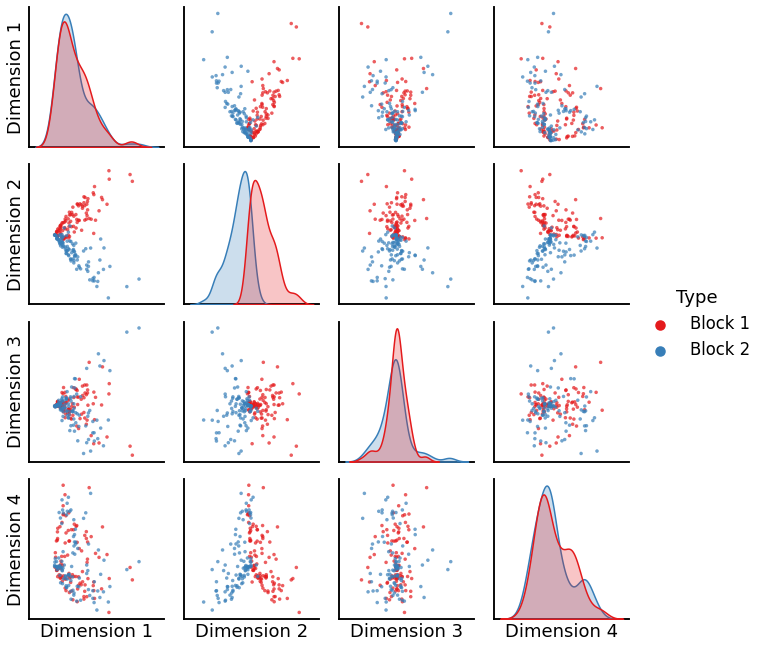

In [24]:
bat2 = ase_graphs[4]

plot_bat2 = pairplot(bat2, pairplot_labels)
#plt.figure(facecolor='w')
plt.savefig('pairplot_bat2.jpg', bbox_inches='tight')

## Discriminability Plot

We will use the [One Sample Discriminability](https://mgc.neurodata.io/api/generated/hyppo.discrim.discrimonesample) test from [hyppo](https://mgc.neurodata.io/index.html) to compare the performance of each kernel. The distance matrix of the embeddings ater using Omnibus is included as a point of comparison.

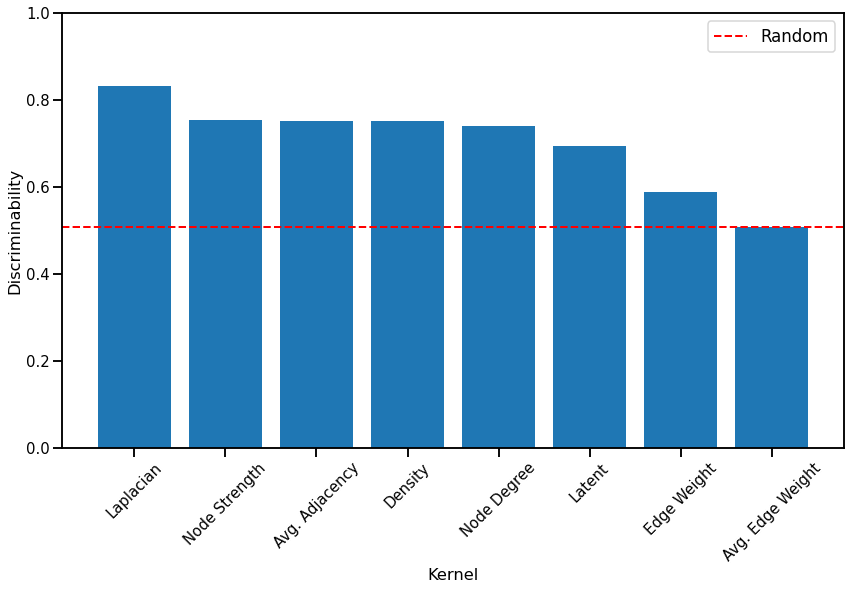

In [26]:
# HIDE CODE

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

# construct integer labels
mapper = {}
unique_labels = np.unique(np.array(labels))
for i, label in enumerate(unique_labels):
    mapper[label] = i
y = np.array([mapper[l] for l in labels])

# construct random matrix with zero diagonal
np.random.seed(3)
scaled_random = np.random.rand(len(graphs), len(graphs))
np.fill_diagonal(scaled_random, 0)

# calculate discriminability for each kernel matrix
discrim_latent = discrim.statistic(scaled_latent_dissim, y)
discrim_density = discrim.statistic(scaled_density_dissim, y)
discrim_avgedgeweight = discrim.statistic(scaled_avgedgeweight_dissim, y)
discrim_avgadjmat = discrim.statistic(scaled_avgadjmat_dissim, y)
discrim_lap = discrim.statistic(scaled_lap_dissim, y)
discrim_nodedeg = discrim.statistic(scaled_nodedeg_dissim, y)
discrim_nodestr = discrim.statistic(scaled_nodestr_dissim, y)
discrim_edgeweight = discrim.statistic(scaled_edgeweight_dissim, y)
discrim_random = discrim.statistic(scaled_random, y)

# plot bar graph in descending order
kernels = ['Latent', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Node Degree', 'Node Strength', \
    'Edge Weight', 'Laplacian']
stats = [discrim_latent, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_nodedeg, \
    discrim_nodestr, discrim_edgeweight, discrim_lap]

discrim_dict = {}
for i, kernel in enumerate(kernels):
    discrim_dict[kernel] = stats[i]

sorted_discrim_dict = dict(sorted(discrim_dict.items(), key=lambda x:x[1], reverse=True))

mami_discrim_fig, ax = plt.subplots(figsize=(14,8), facecolor='w')
mami_discrim_fig = sns.set_context("talk", font_scale=1)
plt.bar(list(sorted_discrim_dict.keys()), list(sorted_discrim_dict.values()))
plt.axhline(y=discrim_random, color='r', linestyle='--', linewidth=2, label='Random')
plt.xticks(rotation=45)
plt.ylim([0, 1.0])
plt.xlabel('Kernel')
plt.ylabel('Discriminability')
plt.legend()

glue("mami_discrim", mami_discrim_fig, display=False)